In [1]:
import os
import subprocess
from bs4 import BeautifulSoup
import pandas as pd
import re
from datetime import datetime, timedelta

dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))
file_path = dir_path.capitalize() + r"\battery-report\battery-report.html"

command = f'powercfg /batteryreport /output "{file_path}"'
subprocess.run(command, shell=True)

with open(file_path, "r", encoding="utf-8") as file:
    soup = BeautifulSoup(file, "html.parser")

def fill_missing_dates(times):
    last_date = None
    new_times = []

    for time in times:
        if " " in time:  # Full timestamp present
            last_date = time.split(" ")[0]  # Extract date part
            new_times.append(time)
        else:  # Only time is present, prepend last known date
            new_times.append(f"{last_date} {time}" if last_date else time)

    return new_times

def extract_time_percentage(column):
    time_values = []
    percent_values = []
    
    for value in column.astype(str):
        match = re.search(r"(\d{1,2}:\d{2}:\d{2})\s*(\d+)%?", value)
        if match:
            time_values.append(match.group(1))  # Extract time
            percent_values.append(match.group(2))  # Extract percentage
        else:  # If no match, default to empty values
            time_values.append("")
            percent_values.append("")
    
    return time_values, percent_values

def find_table_value(label):
    """Finds the value next to a label in a table, handling missing elements safely."""
    cell = soup.find("td", string=lambda text: text and label.lower() in text.lower())
    return cell.find_next_sibling("td").text.strip() if cell else "N/A"

system_info = {
    "Computer Name": find_table_value("COMPUTER NAME"),
    "System Product Name": find_table_value("SYSTEM PRODUCT NAME"),
    "OS Build": find_table_value("OS BUILD"),
    "BIOS": find_table_value("BIOS"),
    "Report Time": find_table_value("REPORT TIME")
}

battery_details = {
    "Battery Name": find_table_value("NAME"),
    "Manufacturer": find_table_value("MANUFACTURER"),
    "Chemistry": find_table_value("CHEMISTRY"),
    "Design Capacity": find_table_value("DESIGN CAPACITY"),
    "Full Charge Capacity": find_table_value("FULL CHARGE CAPACITY"),
}

def extract_table(section_header):
    """Extracts table data under a given section header."""
    section = soup.find("h2", string=lambda text: text and section_header.lower() in text.lower())
    if not section:
        return pd.DataFrame()  
    
    table = section.find_next("table")
    if not table:
        return pd.DataFrame()

    rows = []
    for row in table.find_all("tr", class_=["even", "odd"]):
        cols = [td.get_text(strip=True) for td in row.find_all("td")]
        if cols:  
            rows.append(cols)

    first_row = table.find("tr")
    headers = [th.get_text(strip=True) for th in first_row.find_all("th")]

    max_columns = max(len(row) for row in rows) if rows else 0
    if not headers or len(headers) != max_columns:
        headers = [f"Column_{i+1}" for i in range(max_columns)]

    return pd.DataFrame(rows, columns=headers)

def clean_energy_value(value):
    """Cleans energy values by removing 'mWh', commas, and converting to numeric."""
    if isinstance(value, str):
        # Remove 'mWh', commas, and spaces
        value = value.replace('mWh', '').replace(',', '').strip()
        # Remove any surrounding quotes
        value = value.strip('"')
        # Try to convert to float, return 0 if not possible
        try:
            return float(value)
        except ValueError:
            return 0
    return value


recent_usage = extract_table("Recent usage")
battery_usage = extract_table("Battery usage")
usage_history = extract_table("Usage history")
battery_capacity_history = extract_table("Battery capacity history")
battery_life_estimates = extract_table("Battery life estimates")

pd.DataFrame([system_info]).to_csv(dir_path.capitalize() + r"\battery-report\system_info.csv", index=False)
pd.DataFrame([battery_details]).to_csv(dir_path.capitalize() + r"\battery-report\battery_details.csv", index=False)

recent_usage.columns = [
    "START TIME",
    "STATE",
    "SOURCE",
    "CAPACITY REMAINING PERCENT",
    "CAPACITY REMAINING"
]

# Fix missing spaces between date and time
recent_usage["START TIME"] = recent_usage["START TIME"].astype(str).apply(
    lambda x: re.sub(r'(\d{4}-\d{2}-\d{2})(\d{2}:\d{2}:\d{2})', r'\1 \2', x)
)

# Apply the function
recent_usage["START TIME"] = fill_missing_dates(recent_usage["START TIME"])

# Convert to proper datetime format
recent_usage["START TIME"] = pd.to_datetime(recent_usage["START TIME"], errors="coerce")

# Split 'START TIME' into separate 'DATE' and 'TIME' columns
recent_usage["DATE"] = recent_usage["START TIME"].dt.date
recent_usage["TIME"] = recent_usage["START TIME"].dt.time

# Remove 'START TIME' and reorder columns
recent_usage = recent_usage.drop(columns=["START TIME"])
recent_usage = recent_usage[["DATE", "TIME"] + [col for col in recent_usage.columns if col not in ["DATE", "TIME"]]]
recent_usage["CAPACITY REMAINING"] = recent_usage["CAPACITY REMAINING"].apply(clean_energy_value)

recent_usage.to_csv(dir_path.capitalize() + r"\battery-report\recent_usage.csv", index=False)

battery_usage.columns = [
    "START TIME",
    "STATE",
    "DURATION",
    "ENERGY DRAINED PERCENT",
    "ENERGY DRAINED"
]
# Fix missing spaces between date and time
battery_usage["START TIME"] = battery_usage["START TIME"].astype(str).apply(
    lambda x: re.sub(r'(\d{4}-\d{2}-\d{2})(\d{2}:\d{2}:\d{2})', r'\1 \2', x)
)

# Apply the function
battery_usage["START TIME"] = fill_missing_dates(battery_usage["START TIME"])

# Convert to proper datetime format
battery_usage["START TIME"] = pd.to_datetime(battery_usage["START TIME"], errors="coerce")

# Split 'START TIME' into separate 'DATE' and 'TIME' columns
battery_usage["DATE"] = battery_usage["START TIME"].dt.date
battery_usage["TIME"] = battery_usage["START TIME"].dt.time

battery_usage = battery_usage.drop(columns=["START TIME"])
battery_usage = battery_usage[["DATE", "TIME"] + [col for col in battery_usage.columns if col not in ["DATE", "TIME"]]]
battery_usage["ENERGY DRAINED"] = battery_usage["ENERGY DRAINED"].apply(clean_energy_value)

battery_usage.to_csv(dir_path.capitalize() + r"\battery-report\battery_usage.csv", index=False)

usage_history.drop(usage_history.columns[3], axis=1, inplace=True)
usage_history.columns = [
    "PERIOD",
    "BATTERY DURATION ACTIVE",
    "BATTERY DURATION CONNECTED STANDBY",
    "AC DURATION ACTIVE",
    "AC DURATION CONNECTED STANDBY",
]
def clean_and_fix_period(df, period_column="PERIOD"):
    # Clean up the PERIOD column by removing extra newlines and spaces
    df[period_column] = df[period_column].str.replace(r"\s*\n+\s*", " ", regex=True).str.strip()

    # Identify rows where PERIOD has only one date
    single_date_rows = df[period_column].str.match(r"^\d{4}-\d{2}-\d{2}$", na=False)

    # Fill in missing end dates by using the next row's start date, if available
    for i in df[single_date_rows].index:
        if i + 1 in df.index:  # Ensure the next row exists
            next_date = df.loc[i + 1, period_column].split(" - ")[0]  # Get start date of next period
            df.loc[i, period_column] = f"{df.loc[i, period_column]} - {next_date}"

    # Recalculate the last index
    last_index = df.index[-1]

    # Extract the last start date from the PERIOD column (handling cases with ranges)
    last_date_str = df.loc[last_index, period_column].split(" - ")[0]  # Take only the first date

    # Function to manually increment a date
    def increment_date(date_str):
        year, month, day = map(int, date_str.split("-"))
        days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
        if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
            days_in_month[1] = 29  # Leap year adjustment
        day += 1
        if day > days_in_month[month - 1]:
            day = 1
            month += 1
            if month > 12:
                month = 1
                year += 1
        return f"{year:04d}-{month:02d}-{day:02d}"

    # Compute the next day manually
    next_day_str = increment_date(last_date_str)

    # Update the last row with the calculated next day
    df.loc[last_index, period_column] = f"{last_date_str} - {next_day_str}"

    return df
usage_history = clean_and_fix_period(usage_history)
usage_history.to_csv(dir_path.capitalize() + r"\battery-report\usage_history.csv", index=False)

battery_capacity_history.columns = ["PERIOD", "FULL CHARGE CAPACITY", "DESIGN CAPACITY"]
battery_capacity_history = clean_and_fix_period(battery_capacity_history)
battery_capacity_history["FULL CHARGE CAPACITY"] = battery_capacity_history["FULL CHARGE CAPACITY"].apply(clean_energy_value)
battery_capacity_history["DESIGN CAPACITY"] = battery_capacity_history["DESIGN CAPACITY"].apply(clean_energy_value)


battery_capacity_history.to_csv(dir_path.capitalize() + r"\battery-report\battery_capacity_history.csv", index=False)

battery_life_estimates.drop(battery_life_estimates.columns[3], axis=1, inplace=True)
battery_life_estimates.columns = [
    "PERIOD",
    "AT FULL CHARGE ACTIVE",
    "AT FULL CONNECTED STANDBY",
    "AT DESIGN CAPACITY ACTIVE",
    "AT DESIGN CAPACITY CONNECTED STANDBY"
]
battery_life_estimates = clean_and_fix_period(battery_life_estimates)
battery_life_estimates["CONNECTED_STANDBY_TIME"], battery_life_estimates["CONNECTED_STANDBY_PERCENT"] = extract_time_percentage(
    battery_life_estimates["AT FULL CONNECTED STANDBY"]
)
battery_life_estimates["DESIGN_CONNECTED_STANDBY_TIME"], battery_life_estimates["DESIGN_CONNECTED_STANDBY_PERCENT"] = extract_time_percentage(
    battery_life_estimates["AT DESIGN CAPACITY CONNECTED STANDBY"]
)
battery_life_estimates.drop(['AT FULL CONNECTED STANDBY', 'AT DESIGN CAPACITY CONNECTED STANDBY'], axis=1, inplace=True)

# Reorder the columns as requested
new_column_order = [
    'PERIOD',
    'AT FULL CHARGE ACTIVE',
    'CONNECTED_STANDBY_TIME',
    'CONNECTED_STANDBY_PERCENT',
    'AT DESIGN CAPACITY ACTIVE',
    'DESIGN_CONNECTED_STANDBY_TIME',
    'DESIGN_CONNECTED_STANDBY_PERCENT'
]
battery_life_estimates = battery_life_estimates[new_column_order]

battery_life_estimates.to_csv(dir_path.capitalize() + r"\battery-report\battery_life_estimates.csv", index=False)

print("Extraction Complete! Data Saved as CSV Files.")

Extraction Complete! Data Saved as CSV Files.


Battery Capacity History:
                    PERIOD  FULL CHARGE CAPACITY  DESIGN CAPACITY
0  2023-10-08 - 2023-10-12               92350.0          90006.0
1  2023-10-12 - 2023-10-16               91857.0          90006.0
2  2023-10-16 - 2023-10-25               91397.0          90006.0
3  2023-10-25 - 2023-10-30               91084.0          90006.0
4  2023-10-30 - 2023-11-08               91084.0          90006.0


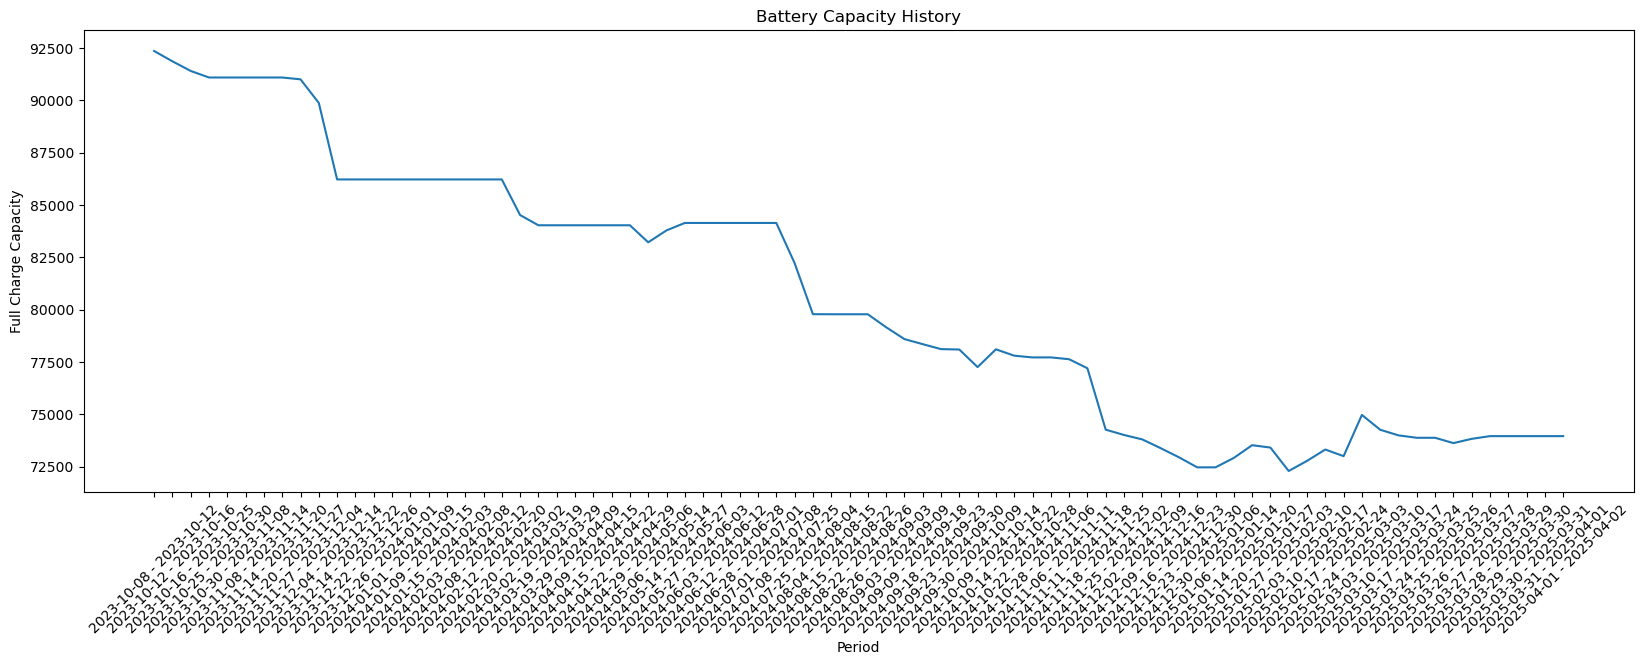

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Get the directory path
dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))

# Load dataset
battery_capacity_history = pd.read_csv(os.path.join(dir_path, 'battery-report', 'battery_capacity_history.csv'))

# Display the first few rows
print("Battery Capacity History:")
print(battery_capacity_history.head())

# Visualization
plt.figure(figsize=(20, 6))
plt.plot(battery_capacity_history['PERIOD'], battery_capacity_history['FULL CHARGE CAPACITY'])
plt.xlabel('Period')
plt.ylabel('Full Charge Capacity')
plt.title('Battery Capacity History')
plt.xticks(rotation=45)
plt.savefig(os.path.join(dir_path, 'battery-report', 'battery_capacity_history.png'), bbox_inches='tight')
plt.close()

In [24]:
import os
import pandas as pd

# Get the directory path
dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))

# Load dataset
battery_details = pd.read_csv(os.path.join(dir_path, 'battery-report', 'battery_details.csv'))

# Display the data
print("Battery Details:")
print(battery_details)

Battery Details:
  Battery Name Manufacturer Chemistry Design Capacity Full Charge Capacity
0         _EJ_         ASUS      LiON      90,006 mWh           71,338 mWh


Battery Life Estimates:
                    PERIOD AT FULL CHARGE ACTIVE CONNECTED_STANDBY_TIME  \
0  2023-10-08 - 2023-10-12               3:07:36                4:45:26   
1  2023-10-12 - 2023-10-16               4:30:52               10:02:24   
2  2023-10-16 - 2023-10-25              58:55:18               26:16:44   
3  2023-10-25 - 2023-10-30               5:47:59                6:14:39   
4  2023-10-30 - 2023-11-08               4:18:10               13:37:26   

   CONNECTED_STANDBY_PERCENT AT DESIGN CAPACITY ACTIVE  \
0                      336.0                   3:02:50   
1                      159.0                   4:25:24   
2                       61.0                  58:01:30   
3                      256.0                   5:43:51   
4                      117.0                   4:15:06   

  DESIGN_CONNECTED_STANDBY_TIME  DESIGN_CONNECTED_STANDBY_PERCENT  
0                       4:38:12                             345.0  
1                       9:50:16         

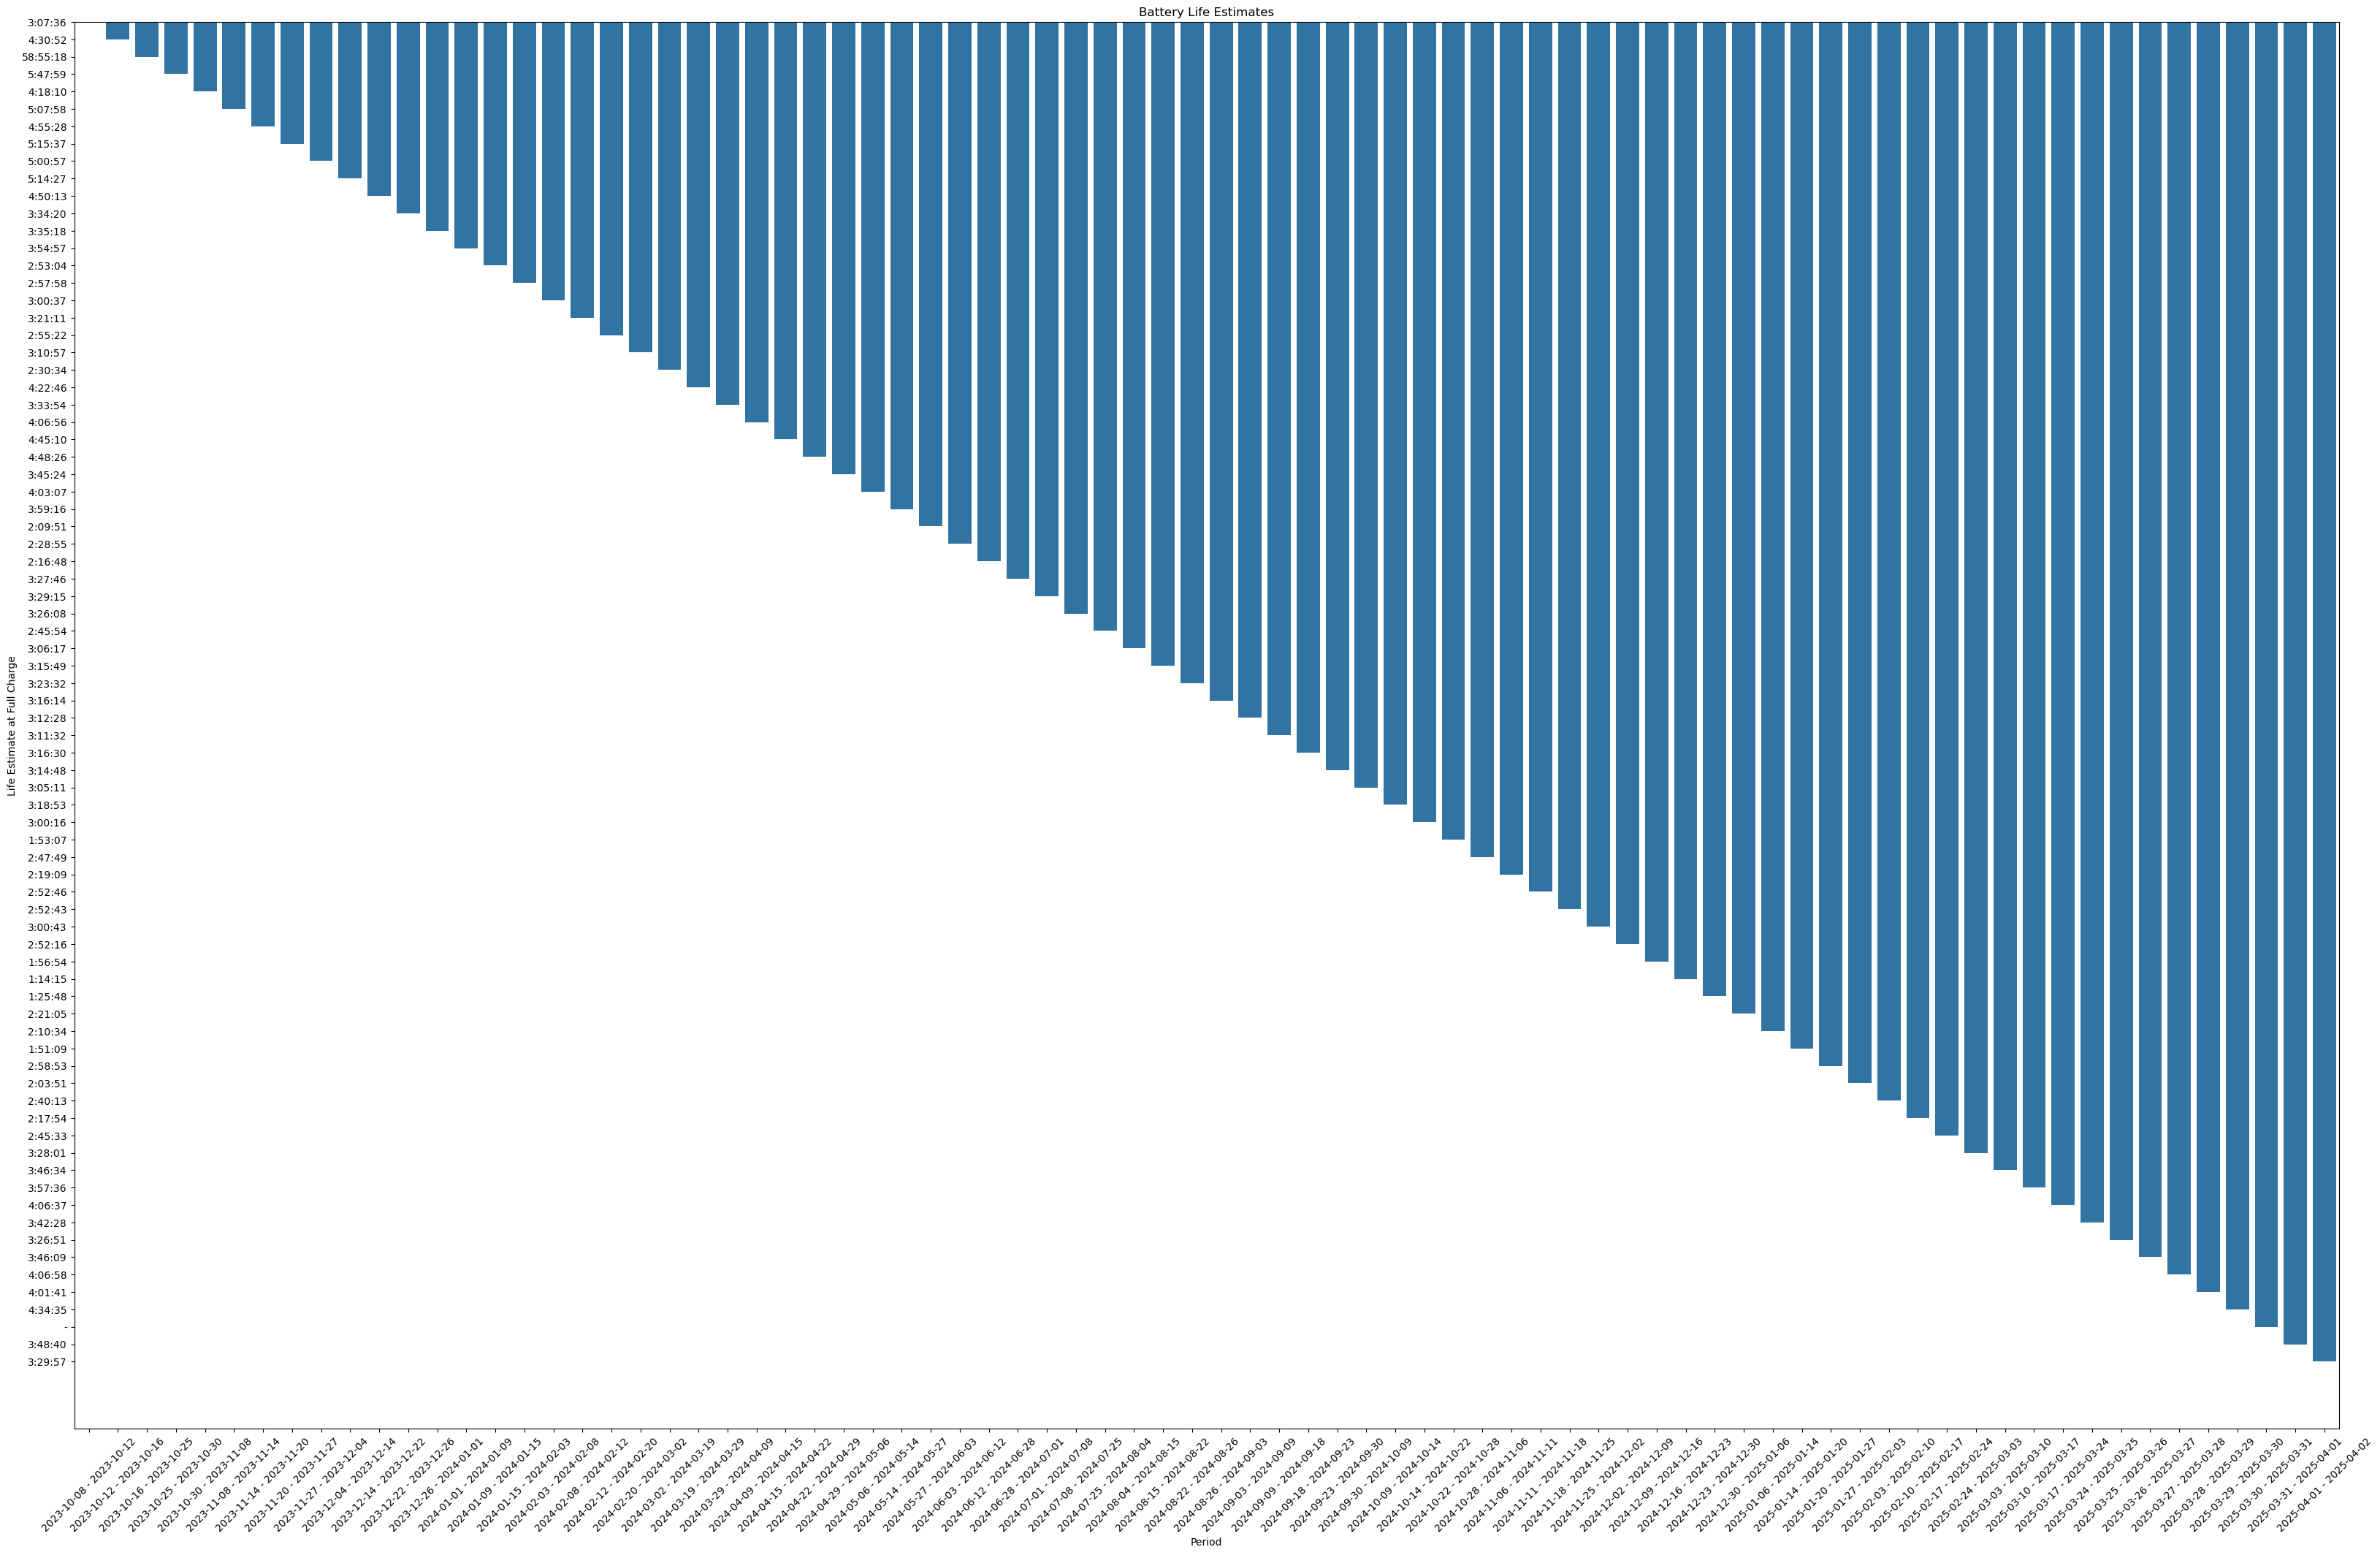

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the directory path
dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))

# Load dataset
battery_life_estimates = pd.read_csv(os.path.join(dir_path, 'battery-report', 'battery_life_estimates.csv'))

# Display the first few rows
print("Battery Life Estimates:")
print(battery_life_estimates.head())

# Visualization
plt.figure(figsize=(40, 25))
sns.barplot(x='PERIOD', y='AT FULL CHARGE ACTIVE', data=battery_life_estimates)
plt.xlabel('Period')
plt.ylabel('Life Estimate at Full Charge')
plt.title('Battery Life Estimates')
plt.xticks(rotation=45)
plt.savefig(os.path.join(dir_path, 'battery-report', 'battery_life_estimates.png'), bbox_inches='tight')
plt.close()

Battery Usage:
         DATE      TIME              STATE DURATION ENERGY DRAINED PERCENT  \
0  2025-03-26  16:33:13             Active  1:15:59                   31 %   
1  2025-03-26  17:49:13  Connected standby  0:15:44                    1 %   
2  2025-03-26  19:26:11  Connected standby  0:00:35                      -   
3  2025-03-26  19:26:47             Active  0:01:14                    1 %   
4  2025-03-26  19:28:01  Connected standby  0:00:00                      -   

   ENERGY DRAINED  
0         22823.0  
1           761.0  
2           269.0  
3           762.0  
4             0.0  


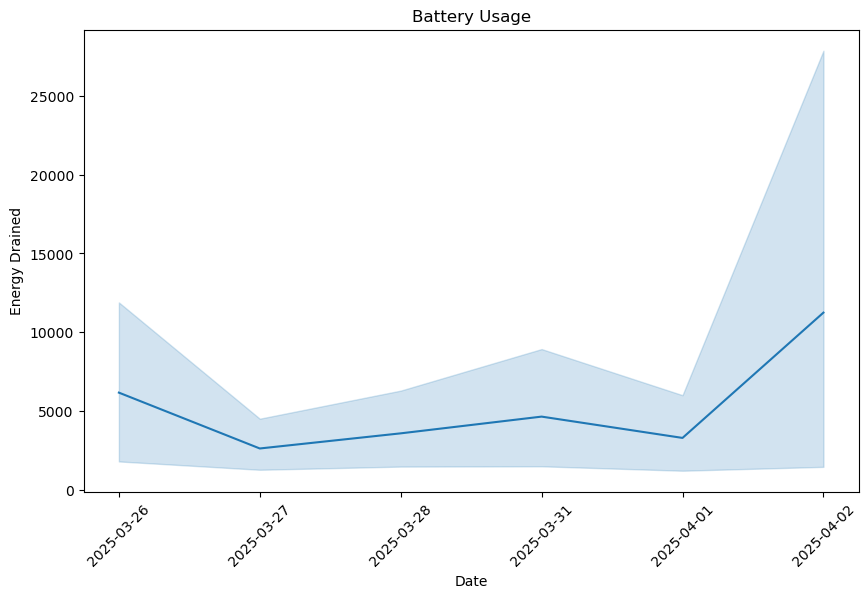

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the directory path
dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))

# Load dataset
battery_usage = pd.read_csv(os.path.join(dir_path, 'battery-report', 'battery_usage.csv'))

# Display the first few rows
print("Battery Usage:")
print(battery_usage.head())

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x='DATE', y='ENERGY DRAINED', data=battery_usage)
plt.xlabel('Date')
plt.ylabel('Energy Drained')
plt.title('Battery Usage')
plt.xticks(rotation=45)
plt.savefig(os.path.join(dir_path, 'battery-report', 'battery_usage.png'), bbox_inches='tight')
plt.close()

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the directory path
dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))

# Load dataset
recent_usage = pd.read_csv(os.path.join(dir_path, 'battery-report', 'recent_usage.csv'))

# Display the first few rows
print("Recent Usage:")
print(recent_usage.head())

# Visualization
plt.figure(figsize=(10, 6))
sns.lineplot(x='DATE', y='CAPACITY REMAINING', data=recent_usage)
plt.xlabel('Date')
plt.ylabel('Capacity Remaining')
plt.title('Recent Usage')
plt.xticks(rotation=45)
plt.savefig(os.path.join(dir_path, 'battery-report', 'recent_usage.png'), bbox_inches='tight')
plt.close()

Recent Usage:
         DATE      TIME   STATE   SOURCE CAPACITY REMAINING PERCENT  \
0  2025-03-26  20:16:15  Active  Battery                       72 %   
1  2025-03-26  20:16:16  Active       AC                       72 %   
2  2025-03-26  20:24:59  Active  Battery                       80 %   
3  2025-03-26  20:25:00  Active       AC                       80 %   
4  2025-03-26  20:28:06  Active  Battery                       83 %   

   CAPACITY REMAINING  
0             53147.0  
1             53147.0  
2             58793.0  
3             58793.0  
4             60760.0  


In [28]:
import os
import pandas as pd

# Get the directory path
dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))

# Load dataset
system_info = pd.read_csv(os.path.join(dir_path, 'battery-report', 'system_info.csv'))

# Display the data
print("System Info:")
print(system_info)

System Info:
  Computer Name                                System Product Name  \
0          _EJ_  ASUSTeK COMPUTER INC. ASUS TUF Gaming F15 FX50...   

                                  OS Build                    BIOS  \
0  26100.1.amd64fre.ge_release.240331-1435  FX506HE.313 03/03/2023   

           Report Time  
0  2025-04-02 15:59:21  


Usage History:
                    PERIOD BATTERY DURATION ACTIVE  \
0  2023-10-08 - 2023-10-12                 1:24:13   
1  2023-10-12 - 2023-10-16                 8:35:29   
2  2023-10-16 - 2023-10-25               218:37:19   
3  2023-10-25 - 2023-10-30                 0:21:56   
4  2023-10-30 - 2023-11-08                 2:50:58   

  BATTERY DURATION CONNECTED STANDBY AC DURATION ACTIVE  \
0                            0:05:06                  -   
1                            0:18:32            0:37:06   
2                            1:21:36            1:58:23   
3                            0:03:51            0:45:48   
4                            1:05:19            1:17:47   

  AC DURATION CONNECTED STANDBY  
0                             -  
1                       0:00:35  
2                       0:01:10  
3                             -  
4                             -  


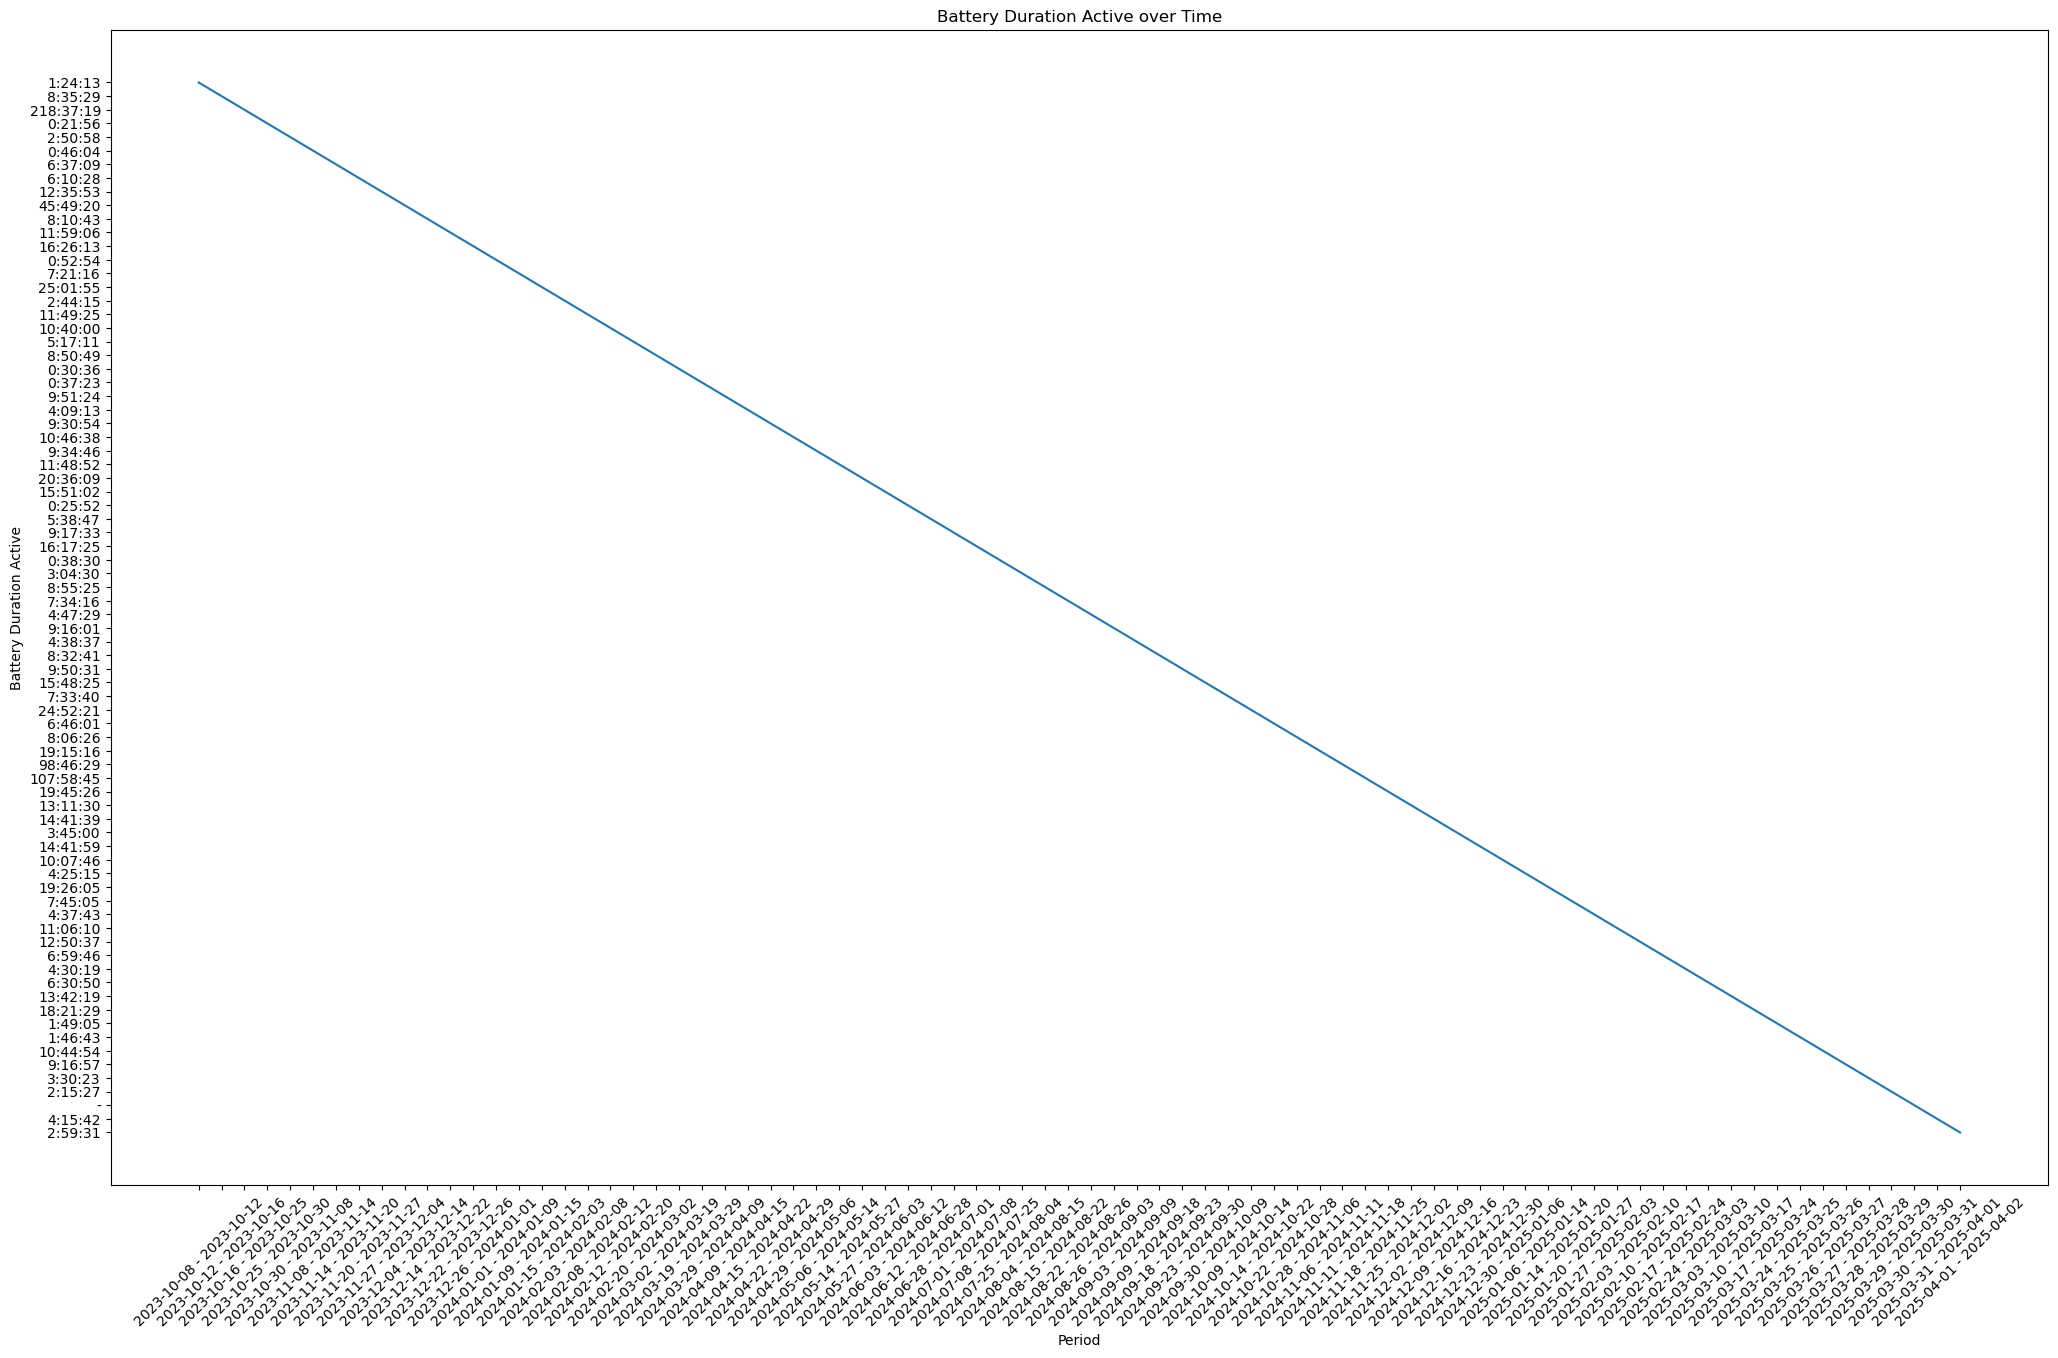

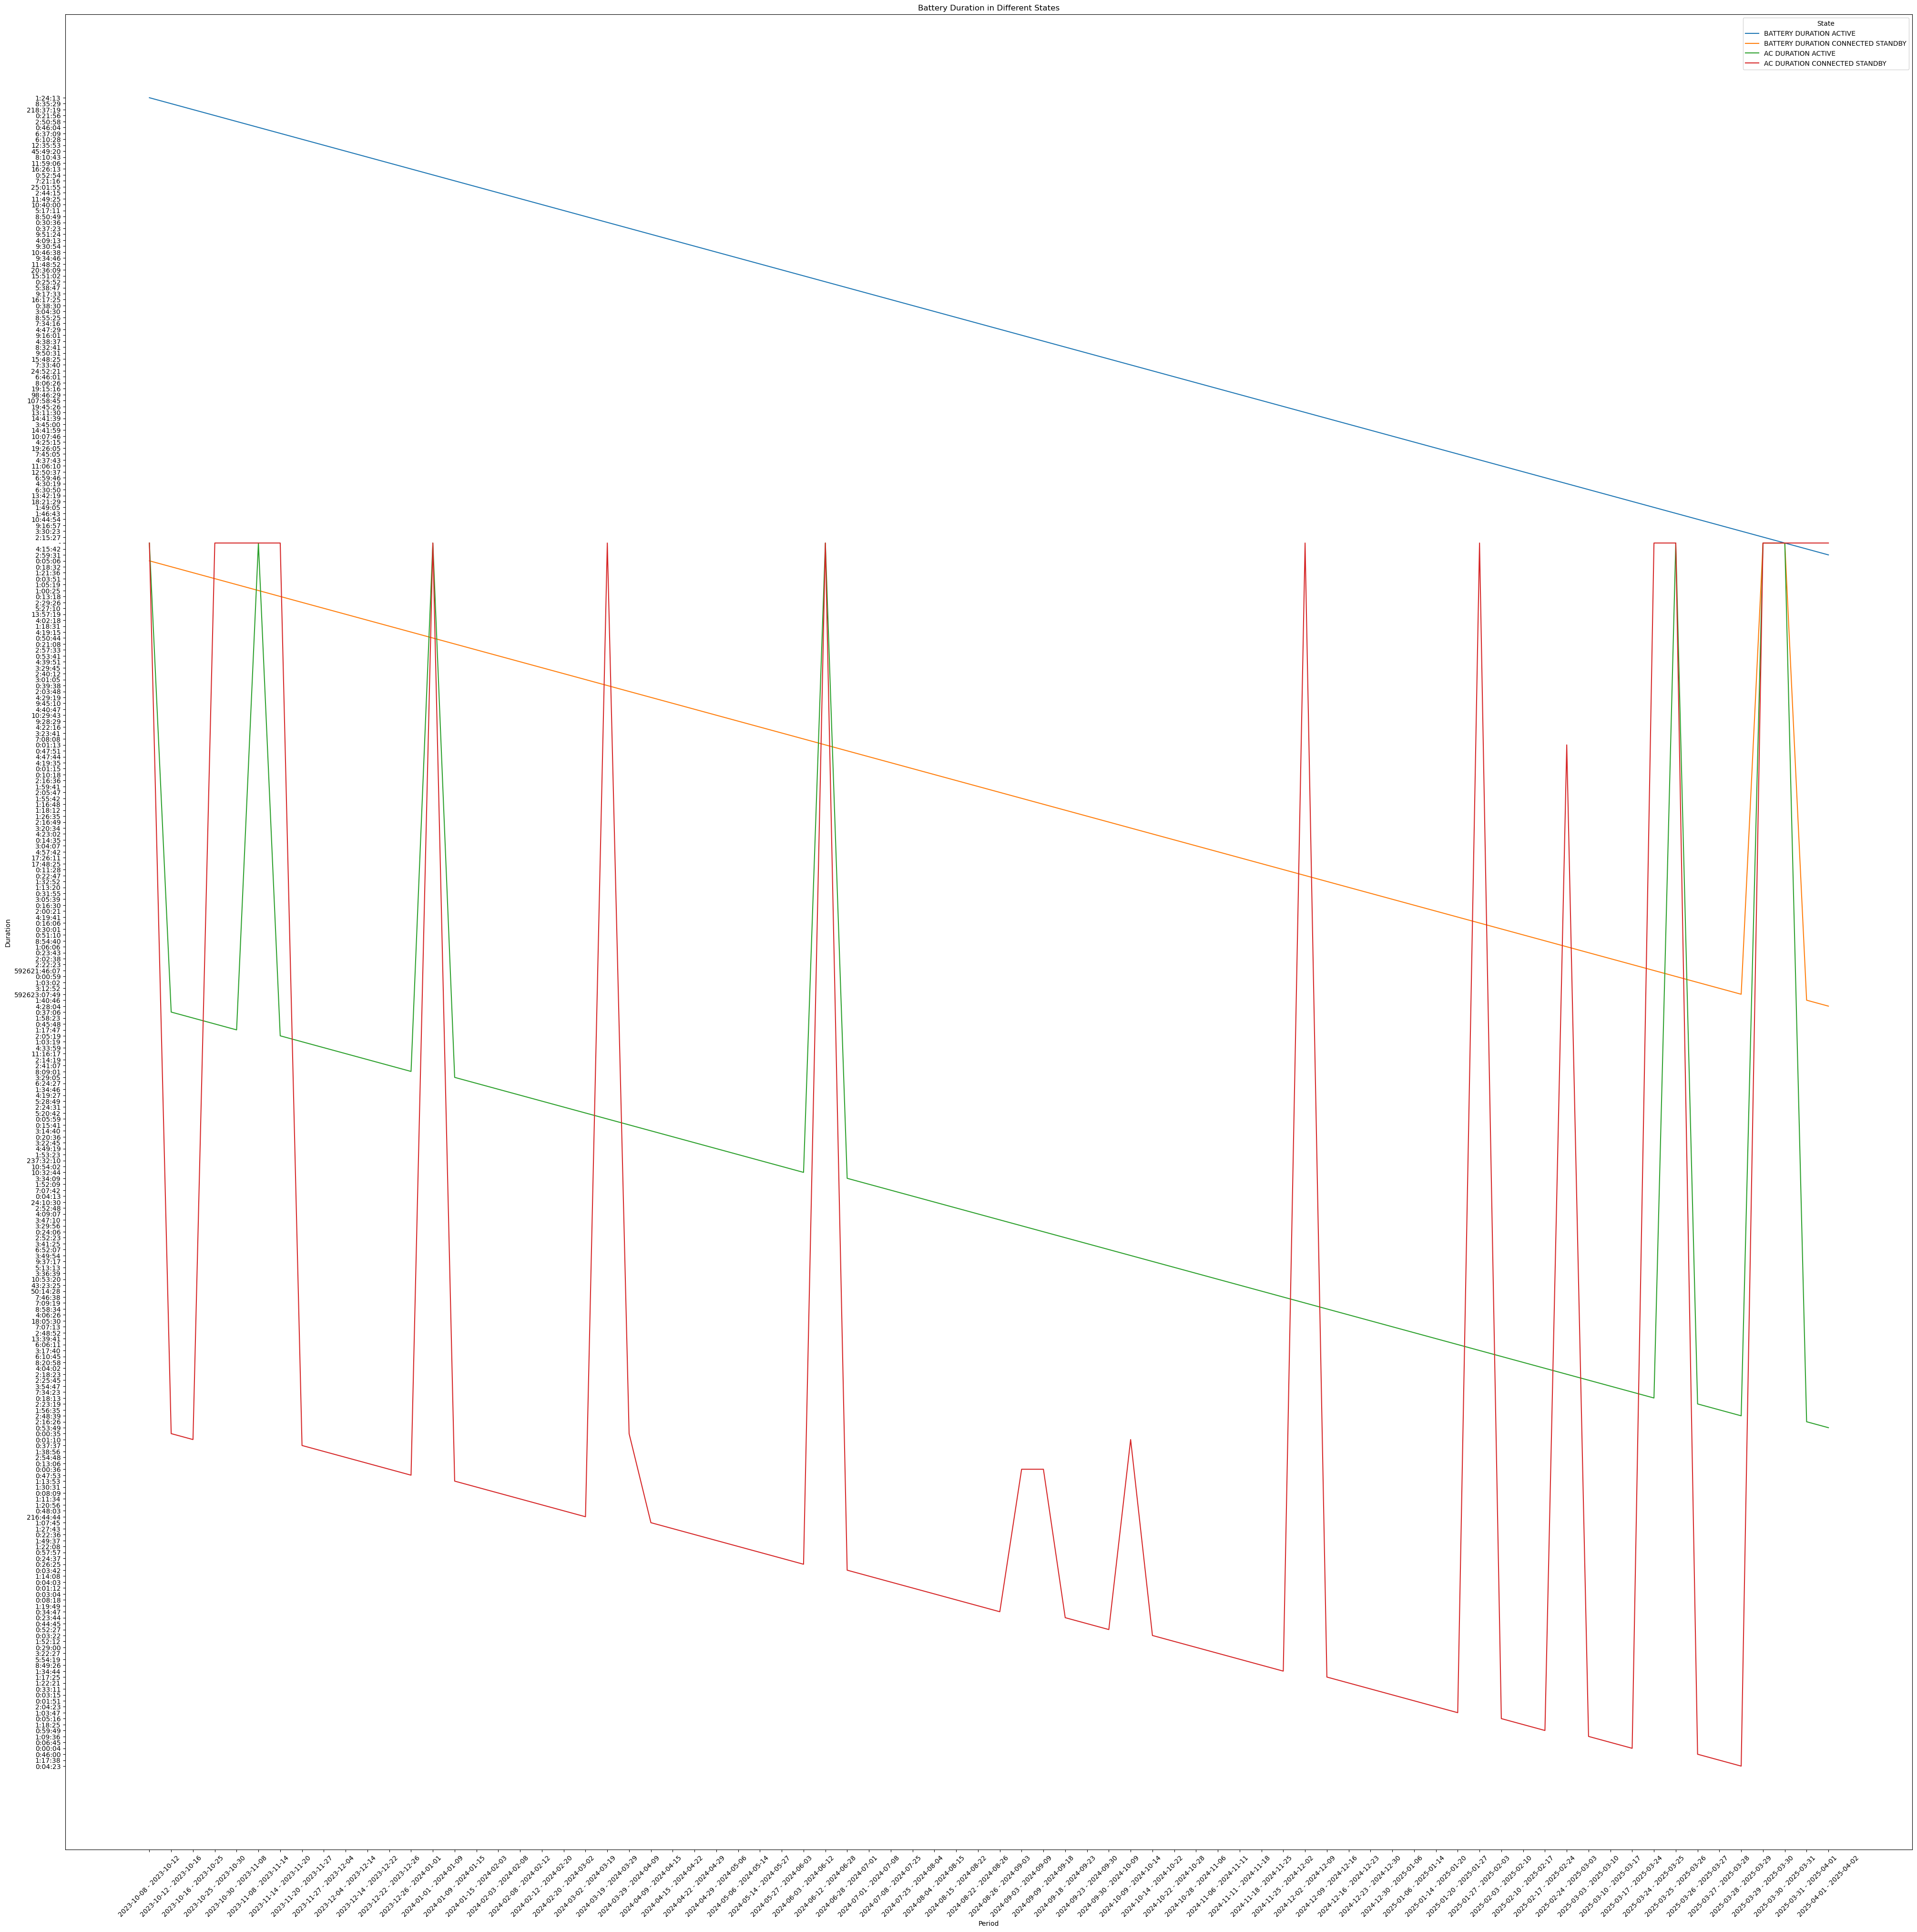

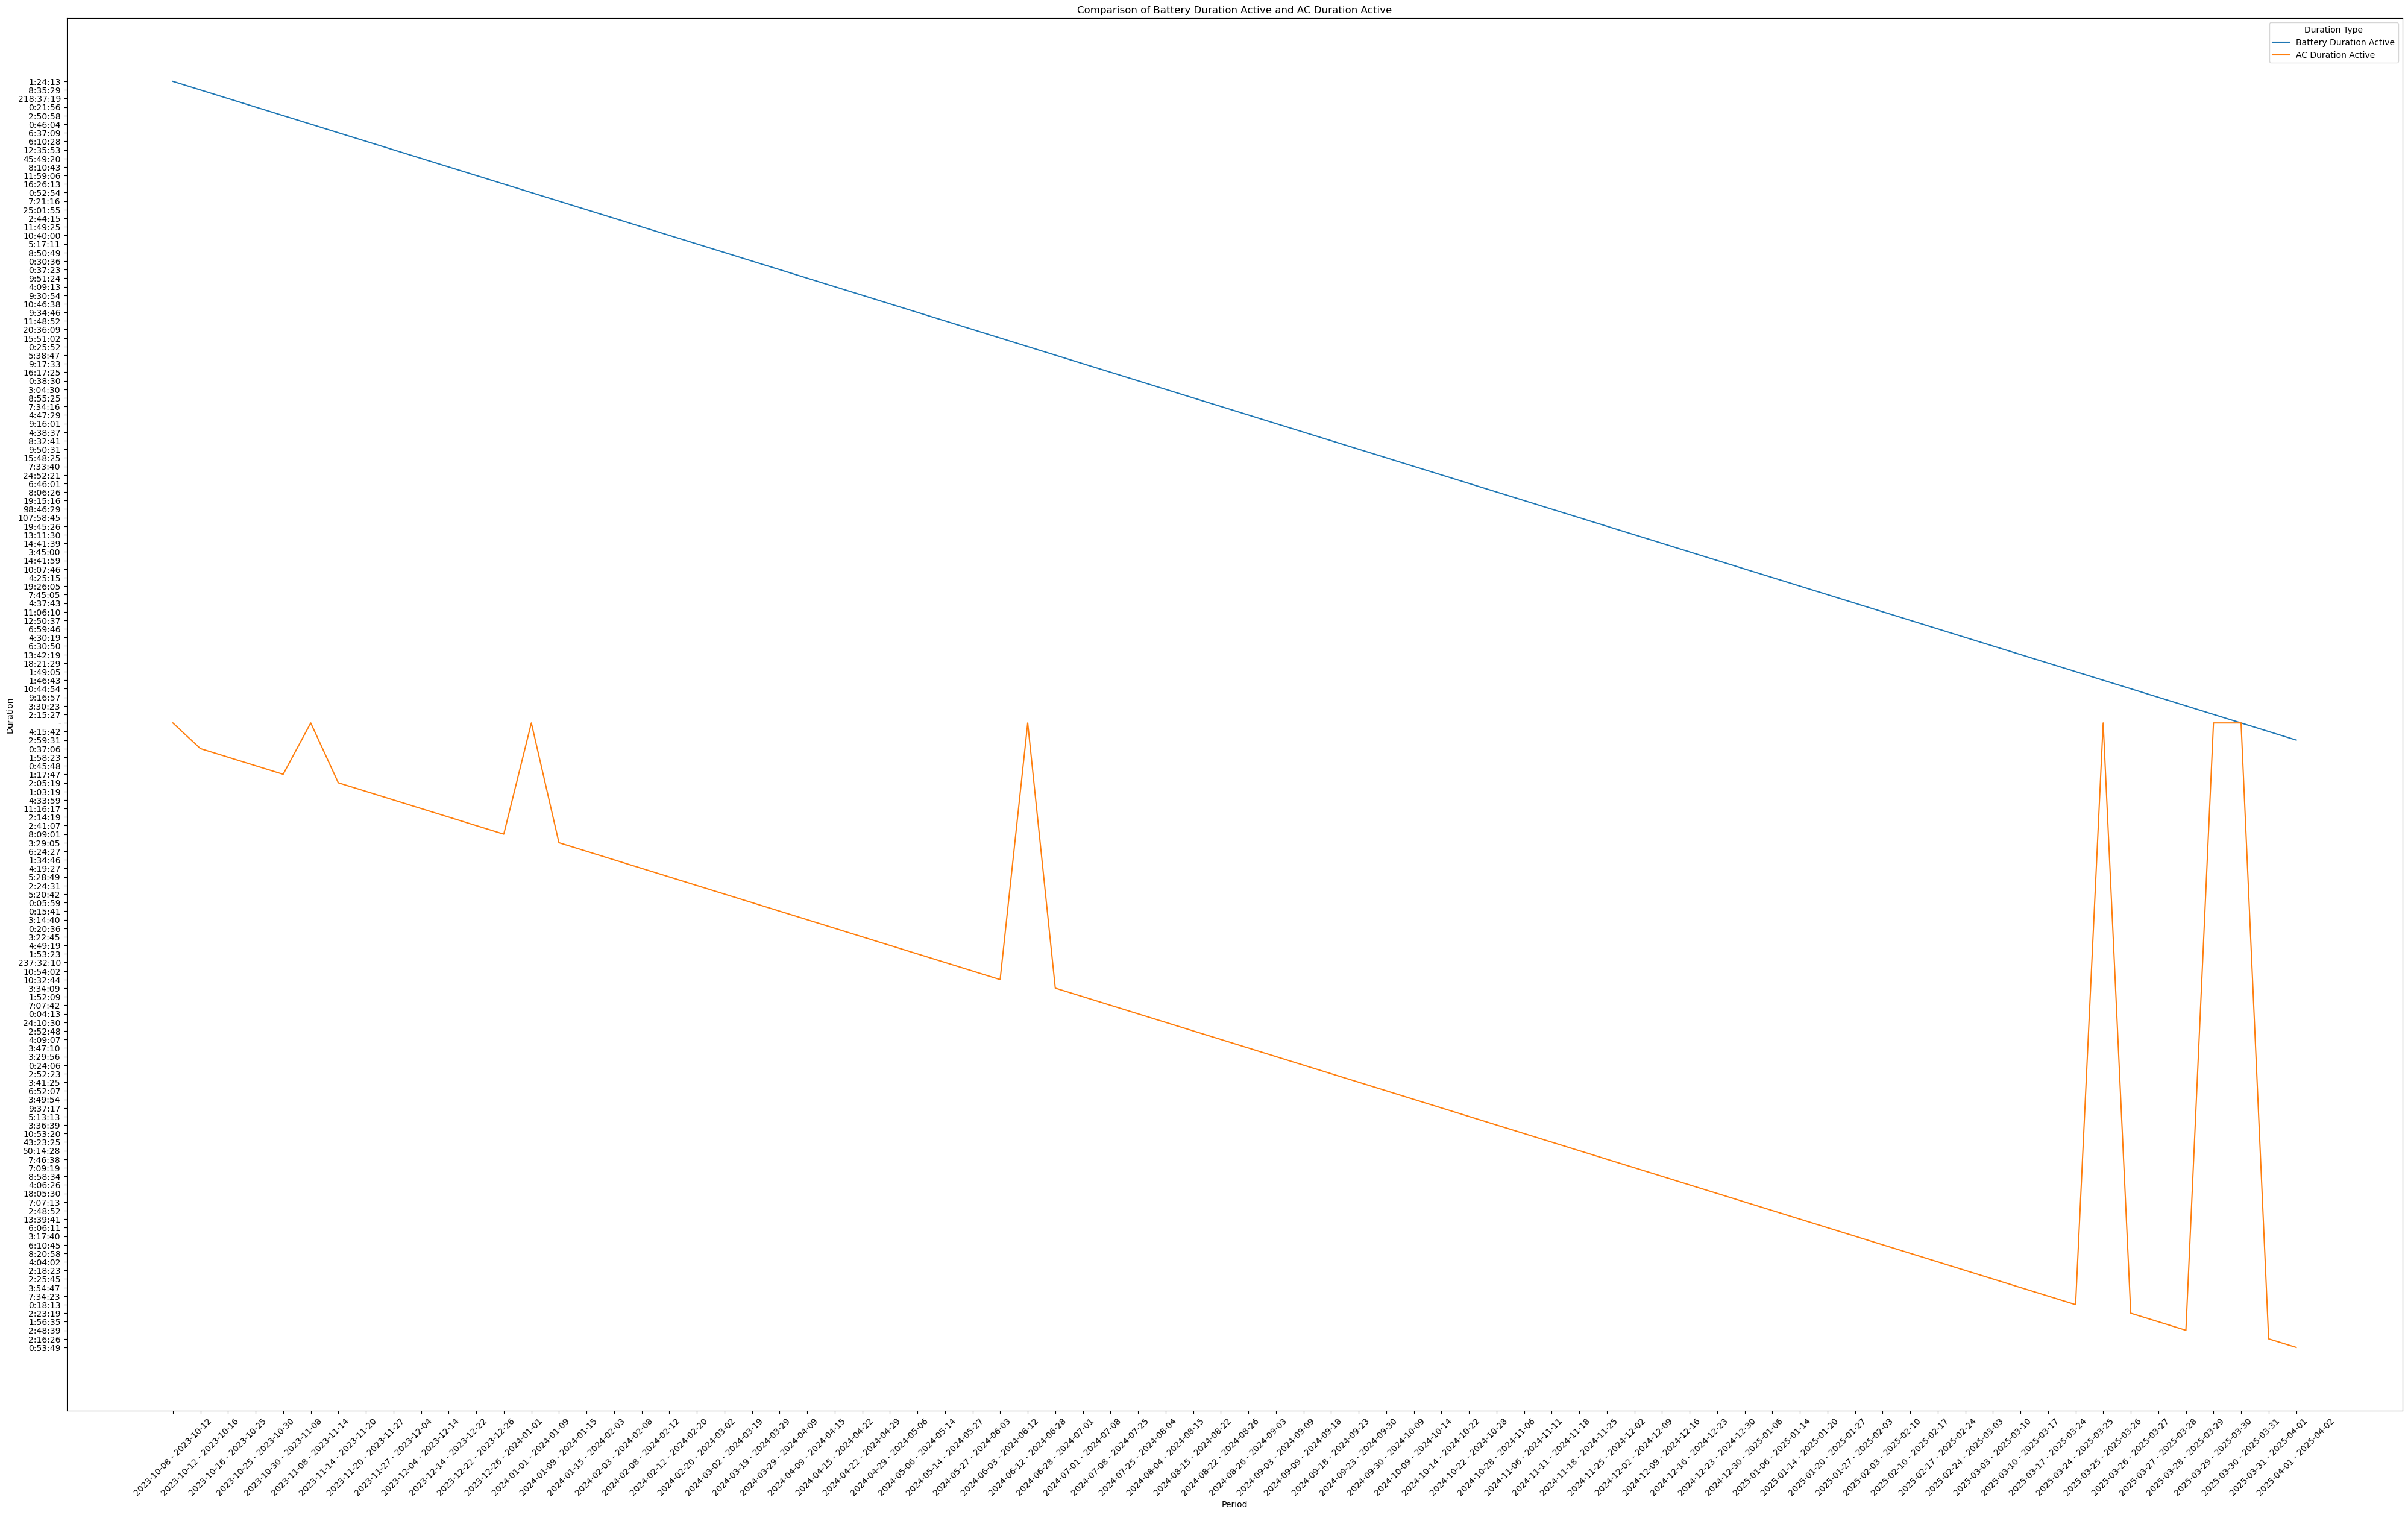

In [ ]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get the directory path
dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))

# Load dataset
usage_history = pd.read_csv(os.path.join(dir_path, 'battery-report', 'usage_history.csv'))

# Display the first few rows
print("Usage History:")
print(usage_history.head())

# Visualization: Battery Duration Active over Time
plt.figure(figsize=(25, 15))
sns.lineplot(x='PERIOD', y='BATTERY DURATION ACTIVE', data=usage_history)
plt.xlabel('Period')
plt.ylabel('Battery Duration Active')
plt.title('Battery Duration Active over Time')
plt.xticks(rotation=45)
plt.savefig(os.path.join(dir_path, 'battery-report', 'battery_duration_active.png'), bbox_inches='tight')
plt.close()

# Visualization: Battery Duration in Different States
plt.figure(figsize=(50, 50))
usage_history_melted = pd.melt(usage_history, id_vars=['PERIOD'], value_vars=['BATTERY DURATION ACTIVE', 'BATTERY DURATION CONNECTED STANDBY', 'AC DURATION ACTIVE', 'AC DURATION CONNECTED STANDBY'])
sns.lineplot(x='PERIOD', y='value', hue='variable', data=usage_history_melted)
plt.xlabel('Period')
plt.ylabel('Duration')
plt.title('Battery Duration in Different States')
plt.xticks(rotation=45)
plt.legend(title='State')
plt.savefig(os.path.join(dir_path, 'battery-report', 'battery_duration_states.png'), bbox_inches='tight')
plt.close()

# Visualization: Comparison of Battery Duration Active and AC Duration Active
plt.figure(figsize=(50, 30))
sns.lineplot(x='PERIOD', y='BATTERY DURATION ACTIVE', data=usage_history, label='Battery Duration Active')
sns.lineplot(x='PERIOD', y='AC DURATION ACTIVE', data=usage_history, label='AC Duration Active')
plt.xlabel('Period')
plt.ylabel('Duration')
plt.title('Comparison of Battery Duration Active and AC Duration Active')
plt.xticks(rotation=45)
plt.legend(title='Duration Type')
plt.savefig(os.path.join(dir_path, 'battery-report', 'battery_ac_duration_comparison.png'), bbox_inches='tight')
plt.close()

In [30]:
import os

dir_path = os.path.dirname(os.path.abspath("os project.ipynb"))
folder_path = dir_path.capitalize() + r"\battery-report"  # Change this path accordingly

for file_name in os.listdir(folder_path):
    file_path = os.path.join(folder_path, file_name)
    if os.path.isfile(file_path):
        os.remove(file_path)

print("All files deleted successfully.")

All files deleted successfully.
